All code copyright joshuah.rainstar@gmail.com joshuah rainstar 2025
ConvexGPT License Applies- Accept License or exit this page

In [1]:
"""
Prepare the Shakespeare dataset for character-level language modeling.
So instead of encoding with GPT-2 BPE tokens, we just map characters to ints.
Will save train.bin, val.bin containing the ids, and meta.pkl containing the
encoder and decoder and some other related info.
"""
import os
import pickle
import requests
import numpy as np
import os
from pathlib import Path

try:
    base_dir = Path(__file__).parent
except NameError:
    base_dir = Path(os.getcwd())  # fallback if __file__ is not defined (e.g. in REPL)
# download the tiny shakespeare dataset
input_file_path = os.path.join(os.path.dirname(base_dir), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = encode(train_data)
val_ids = encode(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile(os.path.join(os.path.dirname(base_dir), 'train.bin'))
val_ids.tofile(os.path.join(os.path.dirname(base_dir), 'val.bin'))

# save the meta information as well, to help us encode/decode later
meta = {
    'vocab_size': vocab_size,
    'itos': itos,
    'stoi': stoi,
}
with open(os.path.join(os.path.dirname(base_dir), 'meta.pkl'), 'wb') as f:
    pickle.dump(meta, f)

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


In [228]:
#copyright joshuah.rainstar@gmail.com 2025
#protected under license and copyright -proprietary software
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from pathlib import Path
from typing import List,Literal

#c1 everywhere BUT logsumexp because of the max

        
class S4DFFT(nn.Module):
    """
    Diagonal State‑Space (S4D) layer with length‑agnostic FFT or recurrent scan.

      x : (B,T,D)  ➜  y : (B,T,D)
    """

    def __init__(
        self,
        d_model: int,
        N: int          = 64,          # # diagonal modes
        init: str       = "hippoD",    # 'hippoD' | 'inverse' | 'linear'
        short_thresh: int = 512,       # switch to recurrent if T ≤ this
        tau_min: float  = 1e-4,        # clamp on exp(log_tau)
    ):
        super().__init__()
        assert N % 2 == 0, "N must be even (conjugate pairs)."

        self.d_model, self.N = d_model, N
        self.tau_min = tau_min

        # unconstrained parameters for N/2 distinct modes
        self.log_tau = nn.Parameter(torch.randn(N // 2))
        self.freq    = nn.Parameter(torch.randn(N // 2))
        self.B       = nn.Parameter(torch.randn(N // 2))
        self.C       = nn.Parameter(torch.randn(N // 2))

        # input/output projections
        self.in_proj  = nn.Linear(d_model, N // 2, bias=False)
        self.out_proj = nn.Linear(N // 2, d_model, bias=False)

        # learnable global time‑scale Δt  (log‑domain)
        self.log_dt = nn.Parameter(torch.zeros(()))

        self._init_modes(init)

    # ----- initialisers --------------------------------------------------
    def _init_modes(self, kind: Literal["hippoD", "inverse", "linear"]):
        n = torch.arange(self.N // 2)
        with torch.no_grad(): 
            self.log_tau.fill_(math.log(0.5))
            if kind == "hippoD":
                self.freq.copy_(math.pi * (2*n + 1) / 2)
            elif kind == "inverse":
                self.freq.copy_((self.N / math.pi) / (2*n + 1))
            elif kind == "linear":
                self.freq.copy_(math.pi * n)
            else:
                raise ValueError(kind)
            nn.init.normal_(self.B,  mean=1.0, std=0.2)
            nn.init.normal_(self.C,  std=1.0 / math.sqrt(self.N/2))

    # ---------------------------------------------------------------------------
    # Real‑only kernel builder
    # ---------------------------------------------------------------------------
    def _kernel_fft(self, T: int):
        """
        Return RFFT(K) where K is the real convolution kernel of length T.
          output: (N, L/2+1) complex
        Everything up to the final rfft is real‑typed.
        """
        L   = self._next_pow_two(2 * T)

        dt   = torch.exp(self.log_dt)                      # scalar
        tau  = torch.exp(self.log_tau).clamp(min=self.tau_min)   # (N/2,)
        angle = self.freq * dt                                   # (N/2,)

        # |lam|  = exp(-tau*dt)            (real)
        # arg(lam)= angle                  (real)
        lam_mag = torch.exp(-tau * dt)                         # (N/2,)
        log_gain = (self.B.abs() + 1e-9).log() + \
                  (self.C.abs() + 1e-9).log()                 # (N/2,)

        i = torch.arange(T, device=tau.device)                 # (T,)

        # amplitude term  (N/2,T)   — still real
        log_lam_mag = lam_mag.log()
        scaled_i = i[None] * log_lam_mag[:, None]
        amp = torch.exp(log_gain[:, None] + scaled_i)

        # phase term
        phase = i[None] * angle[:, None]                       # (N/2,T)

        K_half = amp * torch.cos(phase)                        # (N/2,T) real

        # build full length‑N kernel (conjugate pair ⇒ symmetry in mode index)
        K_full = torch.cat([K_half, K_half.flip(0)], dim=0)     # (N,T) real

        return torch.fft.rfft(K_full, n=L, dim=-1)             # (N,L/2+1) complex

    @staticmethod
    def _next_pow_two(n: int) -> int:
        # smallest power of two ≥ n, in O(1) bit ops
        # (from Hacker’s Delight)
        n = n - 1
        n = n | (n >> 1)
        n = n | (n >> 2)
        n = n | (n >> 4)
        n = n | (n >> 8)
        n = n | (n >> 16)
        n = n | (n >> 16)

        # if you worry about >32‐bit dims, add: n |= (n >> 32)
        return n + 1

    # ----- forward (FFT or scan) ----------------------------------------
    def forward(self, x: torch.Tensor):
        B, T, _ = x.shape
        x_proj  = self.in_proj(x)                               # (B,T,N/2)
        x_modes = torch.cat([x_proj, x_proj.flip(-1)], dim=-1)  # (B,T,N)  real

        L  = self._next_pow_two(2 * T)
        Uf = torch.fft.rfft(x_modes, n=L, dim=1).transpose(1, 2)   # (B,N,L/2+1)

        Kf = self._kernel_fft(T)                                   # (N,L/2+1)
        Yf = Uf * Kf[None]                                         # broadcast

        y_modes = torch.fft.irfft(Yf, n=L, dim=2)[..., :T]          # (B,N,T)
        y_modes = y_modes.transpose(1, 2)                          # (B,T,N)
        y       = y_modes[..., : self.N // 2]                       # (B,T,N/2)
        return self.out_proj(y)

class S4PreMix(nn.Module):
    def __init__(self, embed_dim: int, heads: int):
        super().__init__()
        # compute per-head and inner dimensions
        assert embed_dim % heads == 0, "embed_dim must be divisible by heads"
        self.heads = heads
        self.d_k = embed_dim // heads
        assert self.d_k % 2 == 0 , "self.d_dk must be divisible by 2"

        # choose number of modes = d_k
        self.N_modes = self.d_k//2 #cannot meaningfully use more than self.dk, optimizing for half- a low pass. 
        # S4D preprocessing
        self.s4d = S4DFFT(d_model=self.d_k, N=self.N_modes)
        # QKV projection at inner_dim = embed_dim
        self.qkv = nn.Linear(embed_dim, 3 * embed_dim, bias=False)

    def forward(self, x: torch.Tensor):
        # x: (B, S, embed_dim)
        B, S, E = x.shape
        # apply per-head S4 after projecting to embed_dim
        x = x.view(B * self.heads, S, self.d_k)
        x = self.s4d(x)
        x = x.view(B, S, E)
        # compute QKV
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        # reshape to heads
        q = q.view(B, S, self.heads, self.d_k).transpose(1,2)
        k = k.view(B, S, self.heads, self.d_k).transpose(1,2)
        v = v.view(B, S, self.heads, self.d_k).transpose(1,2)
        return q, k, v

class LinearPreMix(nn.Module):
    def __init__(self, embed_dim: int, heads: int):
        super().__init__()
        assert embed_dim % heads == 0, "embed_dim must be divisible by heads"
        self.heads = heads
        self.d_k = embed_dim // heads
        # direct QKV projection
        self.qkv = nn.Linear(embed_dim, 3 * embed_dim, bias=False)

    def forward(self, x: torch.Tensor):
        # x: (B, S, embed_dim)
        B, S, E = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.view(B, S, self.heads, self.d_k).transpose(1,2)
        k = k.view(B, S, self.heads, self.d_k).transpose(1,2)
        v = v.view(B, S, self.heads, self.d_k).transpose(1,2)
        return q, k, v

class BatchedICNN(nn.Module):
    def __init__(self, in_dim: int, petals: int):
        super().__init__()
        self.in_dim = in_dim
        self.P = petals
        D = in_dim
        # layer dims: D → 2D → D
        self.d1, self.d2 = 2 * D, D

        # first-layer weights: (P, d1, D)
        self.weight_raw_0 = nn.Parameter(self._init_weight(petals, self.d1, D))
        self.bias_0       = nn.Parameter(torch.zeros(petals, self.d1))

        # second-layer weights: (P, d2, d1)
        self.weight_raw_1 = nn.Parameter(self._init_weight(petals, self.d2, self.d1))
        self.bias_1       = nn.Parameter(torch.zeros(petals, self.d2))

        # per-petal residual projection weight: maps 2D → D: shape (P, d1, d2)
        self.z_weight = nn.Parameter(torch.empty(petals, self.d1, self.d2))
        nn.init.kaiming_uniform_(self.z_weight, a=math.sqrt(5))

        # gating scalars
        self.gate_raw_0 = nn.Parameter(torch.full((petals,), -3.0))
        self.gate_raw_1 = nn.Parameter(torch.full((petals,), -3.0))

        self.output_bias = nn.Parameter(torch.zeros(petals, D))
        self.act = nn.Softplus()

    def _init_weight(self, petals: int, d_out: int, d_in: int) -> torch.Tensor:
        w = torch.empty(petals, d_out, d_in)
        with torch.no_grad():
            mean = math.log(math.sqrt(2.0 / d_in))
            nn.init.normal_(w, mean=mean, std=0.2)
        return w

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (..., D)
        orig = x.shape
        x_flat = x.reshape(-1, self.in_dim)          # (N, D)
        N = x_flat.size(0)

        # prepare weights & gates
        w0 = F.softplus(self.weight_raw_0).pow(2)    # (P, 2D, D)
        w1 = F.softplus(self.weight_raw_1).pow(2)    # (P, D, 2D)
        g0 = torch.sigmoid(self.gate_raw_0).view(self.P, 1, 1)  # (P,1,1)
        g1 = torch.sigmoid(self.gate_raw_1).view(self.P, 1, 1)

        # ----- first layer across petals -----
        x_in = x_flat.unsqueeze(0).expand(self.P, N, self.in_dim)       # (P, N, D)
        x_w0 = torch.bmm(x_in, w0.transpose(1,2))                       # (P, N, 2D)
        x_w0 = x_w0 + self.bias_0.unsqueeze(1)                          # (P, N, 2D)
        z0   = self.act(x_w0 * g0)                                      # (P, N, 2D)

        # ----- second layer -----
        x_w1 = torch.bmm(z0, w1.transpose(1,2))                         # (P, N, D)
        x_w1 = x_w1 + self.bias_1.unsqueeze(1)                          # (P, N, D)

        # ----- residual path via bmm -----
        # z_weight: (P, 2D, D), z0: (P, N, 2D) → z_mapped: (P, N, D)
        z_mapped = torch.bmm(z0, self.z_weight)                         # (P, N, D)

        # combine, activate, add final bias
        z1 = self.act(x_w1 * g1 + z_mapped)                             # (P, N, D)
        out = z1 + self.output_bias.unsqueeze(1)                        # (P, N, D)

        # reshape back to original leading dims + (P, D)
        out = out.permute(1, 0, 2)  # (N, P, D)
        lead_dims = list(orig[:-1])                 # e.g. [B, H, T]
        new_shape = lead_dims + [self.P, self.in_dim]  # [B, H, T, P, D]
        return out.reshape(new_shape)

'''
Canonical φ(x) builds φ ∈ ℝ^{B, D_in, K}.

When K=8, D_in=8192, B=128 → φ alone = 8.3M floats.
FFT variant avoids this explicit K-expansion and instead processes one padded array per batch element (ℝ^{B, L} and L ≈ D_in).
caveat: it must be trained. it varies by d_in only. so you need pre-learned kernels.
in practice the error is fairly contained. 

naively, our cost is O(N * D_in * D_in*2 * K) for this model since d_out is always twice d_in and K is always 8:
that's a quadratic term times 16: O(N*embed_dim^2*16).
This fft form scales as : O(N * D_in * (log D_in + K))
In practice, this converges on quasi-linear growth and enables much more massive KAN utilization with minimal cost, provided
you pre-learn the kernels. however, since x varies, how do you prelearn the kernel? simple. you zero-mean it. this ensures the kernels are scale invariant.
This means our more economical KAN module can be quickly instantiated with desired behaviors that approximate nonlinear transformations.

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

# Configuration
D_in = 64
D_out = 128
K = 8
batch_size = 128
epochs = 5000
lr = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def wolf_update(p: torch.Tensor,
                g: torch.Tensor,
                state_p: torch.Tensor,
                lr: float):
    # define your constants here instead of capturing them
    etcerta: float = 0.367879441
    et:      float = 1.0 - etcerta

    # same logic as before
    update    = state_p * et + g * etcerta
    new_state = state_p * et + update * etcerta
    sign_agree = torch.sign(update) * torch.sign(g)
    update    = update + (torch.rand_like(update)*2 - 1) * etcerta * update
    p_new     = torch.where(sign_agree > 0, p - lr * update, p)
    return p_new, new_state
from torch.optim.optimizer import Optimizer
class Wolf(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['p'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        loss = closure() if closure is not None else None
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                state_p = self.state[p]['p']
                p_new, new_state = wolf_update(p.data, p.grad, state_p, lr)
                p.data.copy_(p_new)
                state_p.copy_(new_state)
        return loss

class FixedLayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.dim = dim

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return (x - mean) / (std + self.eps)

# Canonical φ(x) with fixed shifts
class CanonicalPhi(nn.Module):
    def __init__(self, shifts, W, b, D_in):
        super().__init__()
        self.shifts = shifts
        self.W = W
        self.b = b
        self.norm = FixedLayerNorm(D_in)

    def forward(self, x):
        x_norm = self.norm(x)  # Normalize x
        xb = x_norm.unsqueeze(-1) + self.shifts.view(1, 1, K)  # (N, D_in, K)
        phi = F.softplus(xb)  # (N, D_in, K)
        return torch.einsum("nik,dik->nd", phi, self.W) + self.b  # (N, D_out)



# FFT encoder with decoder (trainable linear layer)
class FFTSharedKFilters(nn.Module):
    def __init__(self, K_shifts, D_in, shifts_values):
        super().__init__()
        self.K_shifts = K_shifts
        self.D_in = D_in
        self.D_out = 2 * D_in
        self.L = D_in
        self.Lf = self.L // 2 + 1

        self.log_amp_shifts = nn.Parameter(torch.randn(self.K_shifts, self.Lf) * 0.01)
        self.phase_shifts = nn.Parameter(torch.randn(self.K_shifts, self.Lf) * 0.01)
        self.final_bias = nn.Parameter(torch.zeros(self.D_out))
        self.norm = FixedLayerNorm(D_in)  # Apply normalization

    def forward(self, x):
        N = x.shape[0]
        x_norm = self.norm(x)  # Normalize x

        Xf = torch.fft.rfft(x_norm, n=self.L, dim=-1)  # (N, Lf)
        Kf_shifts = torch.exp(self.log_amp_shifts) * torch.exp(-1j * self.phase_shifts)
        Yf_k = Xf.unsqueeze(1) * Kf_shifts.unsqueeze(0)  # (N, K_shifts, Lf)
        x_time_k = torch.fft.irfft(Yf_k, n=self.L, dim=-1)  # (N, K_shifts, D_in)
        phi_k_d = F.softplus(x_time_k)  # (N, K_shifts, D_in)
        S_n_learned = phi_k_d.sum(dim=[1, 2])  # (N,)
        return S_n_learned.unsqueeze(-1) + self.final_bias.unsqueeze(0)  # (N, D_out)
        
        return pred

shifts = torch.linspace(0.0, 1.0, 8).to(device)

# Initialize models and training targets
fft_model = FFTSharedKFilters(8, D_in, D_out).to(device)
W_ref = nn.Parameter(torch.ones(D_out, D_in, 8), requires_grad=False).to(device)
b_ref = nn.Parameter(torch.zeros(D_out), requires_grad=False).to(device)
canonical_phi_model = CanonicalPhi(shifts, W_ref, b_ref, D_in).to(device)

opt = torch.optim.AdamW(fft_model.parameters(), lr=3e-2)
losses = []

start_time = time.time()
for epoch in range(1, epochs + 1):
    x = torch.randn(batch_size, D_in, device=device)
    with torch.no_grad():
        target  = canonical_phi_model(x)

    pred = fft_model(x)
    loss = F.mse_loss(pred, target)
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch}, loss {loss.item():.4e}")
end_time = time.time()


# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label="FFT Encoder + Linear")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training FFT Encoder to Match φ(x) with Trainable Linear Layer")
plt.grid(True)
plt.legend()
plt.show()

# Report parameters
param_count = sum(p.numel() for p in fft_model.parameters())
print(f"Trainable parameters: {param_count}")
print(f"Training time: {end_time - start_time:.2f} seconds")





'''
class KCN(nn.Module):
    def __init__(self, in_dim: int, petals: int, out_dim: int = None):
        super().__init__()
        self.in_dim  = in_dim
        self.out_dim = out_dim if out_dim is not None else in_dim
        self.P       = petals
        self.k       = 8 #empirically and theoretically, shouldnt exceed min(batch,petals), not important
        D_in, D_out = self.in_dim, self.out_dim

        # — edge-wise basis weights — (P, D_out, D_in, k)
        # we'll later flatten the last two dims to match BatchedICNN’s use of bmm
        self.weight = nn.Parameter(
            torch.stack([
                self._init_weight(1, D_out, D_in)[0] for _ in range(self.k)
            ], dim=-1)  # shape: (D_out, D_in, k)
        )
        self.bias = nn.Parameter(torch.zeros(D_out))


        self.weight2 = nn.Parameter(self._init_weight(petals, D_out, D_out))
        self.bias2   = nn.Parameter(torch.zeros(petals, D_out))
        self.gate_raw2 = nn.Parameter(torch.full((petals,), -3.0))

        # shared Softplus shifts: shape (1, D_in, k)
        shifts = torch.linspace(-1.0, 1.0, self.k ).view(1, 1, self.k )  # shape: (1, 1, k)
        self.register_buffer("shifts", shifts)              # broadcast when used

        # residual projection exactly like BatchedICNN: (P, 2*D_in, D_out)
        self.z_weight = nn.Parameter(torch.empty(petals, 2 * D_in, D_out))
        nn.init.kaiming_uniform_(self.z_weight, a=math.sqrt(5))

        # gating scalars per petal
        self.gate_raw = nn.Parameter(torch.full((petals,), -3.0))

        # final bias per petal/output
        self.output_bias = nn.Parameter(torch.zeros(petals, D_out))
        self.act = nn.Softplus()
   
    
    def _init_weight(self, petals: int, d_out: int, d_in: int) -> torch.Tensor:
        w = torch.empty(petals, d_out, d_in)
        with torch.no_grad():
            mean = math.log(math.sqrt(2.0 / d_in))
            nn.init.normal_(w, mean=mean, std=0.2)
        return w
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (..., D_in)
        orig = x.shape
        x_flat = x.reshape(-1, self.in_dim)       # (N, D_in)
        N = x_flat.size(0)

        # ------------------------------------------------------------
        # 1) compute basis activations φ(x): (N, D_in, k)
        xb  = x_flat.unsqueeze(-1) + self.shifts       # (N, D_in, k)
        phi = F.softplus(xb)                           # (N, D_in, k)

        # flatten φ for bmm
        # reshape to (N, D_in * k)
        phi_flat = phi.reshape(N, self.in_dim * self.k)  

        # reshape weight to (D_in * k, D_out)
        weight_flat = self.weight.reshape(self.in_dim * self.k, self.out_dim)

        # shared projection
        x_proj_shared = phi_flat @ weight_flat + self.bias  # (N, D_out)

        # duplicate to all petals
        x_proj = x_proj_shared.unsqueeze(0).expand(self.P, N, self.out_dim)  # (P, N, D_out)
        g1 = torch.sigmoid(self.gate_raw).view(self.P, 1, 1)
        z0 = self.act(x_proj * g1)  # (P, N, D_out)

        # ------------------------------------------------------------
        # 3) second projection
        w2 = F.softplus(self.weight2).pow(2).transpose(1, 2)  # (P, D_out, D_out)
        z1 = torch.bmm(z0, w2) + self.bias2.unsqueeze(1)      # (P, N, D_out)
        g2 = torch.sigmoid(self.gate_raw2).view(self.P, 1, 1)
        z1 = self.act(z1 * g2)

        # ------------------------------------------------------------
        # 4) residual projection
        x_res_in = torch.cat([x_flat, x_flat], dim=-1)                       # (N, 2*D_in)
        x_res_exp = x_res_in.unsqueeze(0).expand(self.P, N, 2 * self.in_dim)  # (P, N, 2*D_in)
        x_res = torch.bmm(x_res_exp, self.z_weight)                          # (P, N, D_out)

        # ------------------------------------------------------------
        # 5) combine and output
        z_final = self.act(z1 + x_res) + self.output_bias.unsqueeze(1)       # (P, N, D_out)
        out = z_final.permute(1, 0, 2)                                       # (N, P, D_out)
        new_shape = list(orig[:-1]) + [self.P, self.out_dim]
        return out.reshape(new_shape)      


class ConvexGate(nn.Module):
    """
    Convex & bounded gate: g(x) = 1 - exp(-softplus(Wx + b)) ∈ (0,1)
    """
    def __init__(self, in_dim: int):
        super().__init__()
        self.lin = nn.Linear(in_dim, 1, bias=True)
        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = self.softplus(self.lin(x))      # convex, ≥ 0
        return 1.0 - torch.exp(-u)       # convex, ∈ (0,1)

class _FusedLogSumExp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, dim):
        m, _ = x.max(dim=dim, keepdim=True)
        y = x - m
        ex = y.exp()
        s = ex.sum(dim=dim, keepdim=True)
        lse = m + s.log()
        ctx.save_for_backward(ex, s)
        ctx.dim = dim
        return lse

    @staticmethod
    def backward(ctx, grad_output):
        ex, s = ctx.saved_tensors
        dim = ctx.dim
        grad_x = grad_output * (ex / s)
        return grad_x, None

# TorchScript-compatible wrapper
class FusedLogSumExp(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    @torch.jit.ignore
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return _FusedLogSumExp.apply(x, self.dim)



class ScalarHull(nn.Module):
    def __init__(self, in_dim: int, petals: int):
        super().__init__()
        self.in_dim = in_dim
        self.register_buffer('nu',  torch.tensor(1.64872127070012814684865078781416357165))
        self.register_buffer('noise_scale', torch.tensor(1e-5))
        self.petals = KCN(self.in_dim, petals)
        self.gate   = ConvexGate(in_dim)
        self.register_buffer("creative", torch.tensor(True))
        self.register_buffer('eps', torch.tensor(1e-6))
        self.fused_lse_hulls = FusedLogSumExp(dim=-1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (..., D)
        g   = self.gate(x)                                   # (..., 1)

        #creativity toggle here

        if self.creative:
            xg   = (x + torch.randn_like(x) * self.noise_scale) * g # (..., D)
        else:
            xg   = x  * g # (..., D)

        # compute τ using a soft logistic
        r = torch.sqrt(xg.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        tau = torch.exp(0.30343 * r + 0.22159)
        # get each petal’s vector output, then reduce to scalar per petal
        out_all = self.petals(xg)                  # (..., P, D)
        scores  = out_all.mean(dim=-1)             # (..., P)

        # tempered LSE over petals
        # scaled: (..., P) = scores * τ
        scaled = scores * tau                     # broadcasts τ→[...,1]→[...,P]

        lse    = self.fused_lse_hulls(scaled)  # (..., 1)

        # divide by τ and squeeze
        return (lse / tau).squeeze(-1)             # (...,)

class VectorHull(nn.Module):
    def __init__(self, dim: int, petals: int, out_dim: int = None):
        super().__init__()
        self.in_dim = dim
        self.out_dim = out_dim if out_dim is not None else dim
        self.register_buffer('noise_scale', torch.tensor(1e-5))
        self.petals = KCN(self.in_dim, petals)
        self.gate   = ConvexGate(dim)
        self.register_buffer("creative", torch.tensor(True))
        self.register_buffer('eps', torch.tensor(1e-6))
        self.fused_lse_hulls = FusedLogSumExp(dim=-1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (..., in_dim)
        g = self.gate(x)  # (..., 1)

        # apply creativity scaling
        if self.creative:
            xg = (x + torch.randn_like(x) * self.noise_scale) * g  # (..., in_dim)
        else:
            xg = x * g

        # compute τ
        r = torch.sqrt(xg.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        tau = torch.exp(0.30343 * r + 0.22159)  # (..., 1)

        # batched ICNN output (..., P, out_dim)
        out_all = self.petals(xg)  # (..., P, out_dim)

        # scale each vector per petal
        scaled = out_all * tau.unsqueeze(-1)  # (..., P, out_dim)

        # transpose petals to last dim for LSE
        scaled = scaled.transpose(-2, -1)     # (..., out_dim, P)

        # fused LSE over petals
        lse = self.fused_lse_hulls(scaled).squeeze(-1)  # (..., out_dim)

        # divide out τ
        return lse / tau  # (..., out_dim)
        
class ConvexMixer(nn.Module):
    def __init__(self, d_k: int, petals: int, r: int):
        super().__init__()
        self.register_buffer('eps', torch.tensor(1e-6))
        self.register_buffer('noise_scale', torch.tensor(1e-5))

        self.score_q = ScalarHull(d_k, petals)
        self.score_k = ScalarHull(d_k, petals)
        self.gate = nn.Softplus()
        self.lin_h_q = nn.Linear(d_k, r, bias=False)
        self.lin_h_k = nn.Linear(d_k, r, bias=False)
        self.register_buffer('creative', torch.tensor(True))
        self.fused = FusedLogSumExp(dim=-1)

    def forward(self, q, k, v, mask):
        B, H, S, D = q.shape
        device = q.device

        # ——— 1) tau ———
        gate_q = self.gate(q)                          # (B,H,S,d_k)
        q = q * gate_q
        r = torch.sqrt(q.pow(2).mean(-1, keepdim=True) + self.eps)
        tau = torch.exp(0.30343 * r + 0.22159)  # or + tau_min

        # ——— 2) scalar hull scores ———
        fq = self.score_q(q)  # (B,H,S)
        gk = self.score_k(k)  # (B,H,S)
        if self.creative:
            qn = (torch.rand_like(q) - 0.5) * self.noise_scale
            kn = (torch.rand_like(k) - 0.5) * self.noise_scale
            fq_ = self.score_q(q + qn)
            gk_ = self.score_k(k + kn)
            delta_fq = (fq_ - fq).detach()
            delta_gk = (gk_ - gk).detach()
            fq = fq - 0.1 * delta_fq
            gk = gk - 0.1 * delta_gk

        # ——— 3) random-feature kernel ———
        phi_q = self.gate(self.lin_h_q(q).clamp(max=20.0))
        phi_k = self.gate(self.lin_h_k(k).clamp(max=20.0))
        log_phi_q = torch.log(phi_q + self.eps)
        log_phi_k = torch.log(phi_k + self.eps)
        sum_ab = log_phi_q.unsqueeze(-2) + log_phi_k.unsqueeze(-3)  # (B,H,S,S,r)
        logK = self.fused(sum_ab).squeeze(-1)                        # (B,H,S,S)

        # 5) Assemble logits with mask and temperature
        log_mask = torch.log(mask.clamp_min(self.eps))  # convert to log-domain
        scores = fq.unsqueeze(-1) + gk.unsqueeze(-2) + logK + log_mask  # additive
        
        logits = scores * tau.squeeze(-1).unsqueeze(-1)
        log_weights = logits - torch.logsumexp(logits, dim=-1, keepdim=True)
        weights = torch.exp(log_weights)  # (B,H,S,S)

        # 6) Weighted sum for attention output
        out = weights.reshape(B * H, S, S).bmm(v.reshape(B * H, S, D))
        out = out.reshape(B, H, S, D)

        # Optional: compute aggregated attn_score
        attn_score = weights.sum(dim=-3)
        attn_score = torch.softmax(attn_score, dim=-1).mean(dim=1)
        min_vals = attn_score.min(dim=-1, keepdim=True).values
        max_vals = attn_score.max(dim=-1, keepdim=True).values
        attn_score = (attn_score - min_vals) / (max_vals - min_vals + self.eps)

        return out, attn_score


        
class InterleavedPhaseChannelizer(nn.Module):
    """
    Embedding shape: (B, T, 2*M) == [c0, ϕ0, c1, ϕ1, ..., c_{M-1}, ϕ_{M-1}].
    Now uses a convex bump kernel instead of sine.
    """
    def __init__(self, embed_dim: int, init_gate_bias: float = -3.0, eps: float = 1e-6):
        super().__init__()
        assert embed_dim % 2 == 0, "embed_dim must be even"
        self.M = embed_dim // 2
        self.gate_raw = nn.Parameter(torch.full((self.M,), init_gate_bias))
        self.softplus = nn.Softplus()
        self.eps = eps

    def bump_kernel(self, T: int, device: torch.device):
        """
        Returns a (T, T) kernel K[i,j] ∈ (0,1], convex in |j-i|,
        with K[i,i]=1, and smoothly → eps as j→end.
        """
        i = torch.arange(T, device=device).unsqueeze(1).float()      # (T,1)
        j = torch.arange(T, device=device).unsqueeze(0).float()      # (1,T)

        # future offset u = (j - i) / (T - i)
        diff    = (j - i).clamp(min=0.0)                            # (T,T)
        horizon = (T - i).clamp(min=1.0)                            # (T,1)
        u       = (diff / horizon).clamp(max=1.0 - self.eps)        # [0,1)

        # bump exponent: convex, =1 at u=0, → -∞ as u→1
        expnt = 1.0 - 1.0 / (1.0 - u*u + self.eps)
        K      = torch.exp(expnt)                                   # (T,T)

        # enforce exact eps at u≈1
        K = torch.where(u >= 1.0 - self.eps, torch.full_like(K, self.eps), K)
        return K  # (T,T)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        # x: (B, T, 2*M)
        B, T, _ = x.shape
        M       = self.M
        device  = x.device
        dtype   = x.dtype

        # 1) content channels
        x_c = x[..., 0::2]  # (B, T, M)

        # 2) build convex bump kernel and mask it
        K = self.bump_kernel(T, device).to(dtype)   # (T,T)
        causal2d = mask.view(T, T).to(dtype)        # (T,T)
        K = K * causal2d                            # zero out masked-out positions

        # 3) normalize rows to sum=1
        K = K / (K.sum(-1, keepdim=True).clamp(min=self.eps))

        # 4) accumulate phase φ[b,i,m] = ∑₍ⱼ₌₀…T₋₁₎ K[i,j] · x_c[b,j,m]
        φ = torch.einsum('ij,bjm->bim', K, x_c)     # (B, T, M)

        # 5) gate & write back into odd slots
        gate = self.softplus(self.gate_raw).view(1,1,M)  # (1,1,M)
        φg   = φ * gate                                 # (B, T, M)
        out  = x.clone()
        out[..., 1::2] = φg
        return out

class ConvexRoPE(nn.Module):
    """
    Convex RoPE substitute with dynamic sequence length.
    Generates a monotonic, convex angle for each position-pair subspace.
    """
    def __init__(self, d_k: int):
        super().__init__()
        assert d_k % 2 == 0, "d_k must be even for pairing"
        self.d_pair = d_k // 2
        # Linear mapping from scalar pos to angle per pair
        self.lin = nn.Linear(1, self.d_pair)

    def forward(self, S: int, device: torch.device) -> torch.Tensor:
        # positions normalized to [0,1]
        pos = torch.arange(S, device=device, dtype=torch.float32).unsqueeze(1) / max(S - 1, 1)
        θ = F.softplus(self.lin(pos))  # (S, d_pair), convex & ≥0
        return θ  # shape (S, d_pair)

from typing import Tuple
def apply_convex_rope(q: torch.Tensor, k: torch.Tensor, θ: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:    
    """
    Apply ConvexRoPE rotation to q and k.
      q, k: (B, H, S, d_k)
      θ:    (S, d_k//2)
    Returns rotated q, k of same shape.
    """
    B, H, S, d_k = q.shape
    d2 = d_k // 2

    # reshape into (paired) shape
    q_ = q.view(B, H, S, d2, 2)
    k_ = k.view(B, H, S, d2, 2)

    # split into even (x) and odd (y) parts
    x_q, y_q = q_.unbind(-1)  # each (B, H, S, d2)
    x_k, y_k = k_.unbind(-1)

    # build cos/sin with correct shape (1,1,S,d2) to broadcast
    cosθ = torch.cos(θ).unsqueeze(0).unsqueeze(0)  # (1,1,S,d2)
    sinθ = torch.sin(θ).unsqueeze(0).unsqueeze(0)

    # rotate x/y pairs
    x_q2 = x_q * cosθ - y_q * sinθ
    y_q2 = x_q * sinθ + y_q * cosθ
    x_k2 = x_k * cosθ - y_k * sinθ
    y_k2 = x_k * sinθ + y_k * cosθ

    # stack back into pairs and reshape to original
    q_rot = torch.stack([x_q2, y_q2], dim=-1).reshape(B, H, S, d_k)
    k_rot = torch.stack([x_k2, y_k2], dim=-1).reshape(B, H, S, d_k)

    return q_rot, k_rot
    
# ----------------------------------------------------------------------
#   Pairwise Hull Attention (mask‑aware)
# ----------------------------------------------------------------------
class PairwiseHullAttention(nn.Module):
    def __init__(self, embed_dim, heads,moe_petals, use):
        super().__init__()
        assert embed_dim % heads == 0, "embed_dim must be divisible by heads"
        self.embed_dim = embed_dim
        self.heads = heads
        self.d_k = embed_dim // heads
        if use==0:
            self.pre = S4PreMix(embed_dim, heads)
        else:
            self.pre = LinearPreMix(embed_dim, heads)
        self.mixer = ConvexMixer(self.d_k, moe_petals, self.d_k*2)#dont need many for scoring
        self.W_O = nn.Linear(embed_dim, embed_dim, bias=False)
        self.phase = InterleavedPhaseChannelizer(embed_dim)
        self.register_buffer('noise_scale', torch.tensor(1e-5))
        self.register_buffer("creative", torch.tensor(True))
        self.rope = ConvexRoPE(self.d_k)

    def forward(self, x, mask=None):
        self.phase(x,mask) #apply in-place positional phasing
        B, S, E = x.shape
        Q, K, V= self.pre(x)
        offset = self.rope(S, x.device)                  # (S, d_k//2)
        Q, K = apply_convex_rope(Q, K, offset) 

        mean = 0.5 * (Q.mean() + K.mean())
        std  = 0.5 * (Q.std()  + K.std())
        Q = (Q - mean) / std
        K = (K - mean) / std        
        y,attn_scores = self.mixer(Q, K, V, mask=mask)
        
        y = y.transpose(1, 2).reshape(B, S, self.embed_dim)
        return self.W_O(y), attn_scores

# ----------------------------------------------------------------------
#   OmniHull Block
# ----------------------------------------------------------------------
class OmniHullBlock(nn.Module):
    def __init__(self, dim, heads, moe_petals, use=0):
        super().__init__()
        self.attn = PairwiseHullAttention(dim, heads, moe_petals, use=use)
        self.hff  = VectorHull(dim, moe_petals)

        self.ln1, self.ln2,self.ln3 = nn.LayerNorm(dim), nn.LayerNorm(dim), nn.LayerNorm(dim)
        self.a1, self.a2   = nn.Parameter(torch.zeros(())), nn.Parameter(torch.zeros(()))

    def forward(self, x: torch.Tensor, mask=None):
        x1 ,attn_scores = self.attn(self.ln1(x), mask)
        x = x + x1
        x1 = self.hff(self.ln2(x))
        x = x + x1
        return x,attn_scores

# ----------------------------------------------------------------------
#   GPT Wrapper with Causal Mask
# ----------------------------------------------------------------------
class ConvexGPT(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        depth: int,
        heads: int,
        moe_petals: int,
        creativity: bool = True
    ):
        super().__init__()
        assert embed_dim >= 1, "embed_channels must be ≥1"
        self.embed_channels = embed_dim
        self.embed_dim = 2 * embed_dim

        # Embeddings only for even channels [0,2,4,...]
        self.token_emb = nn.Embedding(vocab_size, embed_dim)

        # Blocks operate on full embed_dim
        self.blocks = nn.ModuleList([
        OmniHullBlock(
            self.embed_dim,
            heads,
            moe_petals,
            use=1 if i == 0 or i == depth - 1 else 0
                  )
            for i in range(depth)
        ])

        self.ln_f = nn.LayerNorm(self.embed_dim)
        self.head = nn.Linear(self.embed_dim, vocab_size, bias=False)
        self.set_creativity(creativity)


    @staticmethod
    def logistic_mask(S: int, eps: float = 1e-17) -> torch.Tensor:
        i = torch.arange(S).unsqueeze(1).float()  # (S,1)
        j = torch.arange(S).unsqueeze(0).float()  # (1,S)
    
        # Compute normalized future offset u = (j - i) / (S - i)
        diff = (j - i).clamp(min=0.0)
        horizon = (S - i).clamp(min=1.0)
        u = (diff / horizon).clamp(max=1.0)  # ∈ [0,1]
    
        # Decay from 1 to eps as u ∈ (0, 1]
        decay = torch.exp(1.0 - 1.0 / (1.0 - u ** 2 + 1e-6))  # smooth bump
        decay = decay.clamp_max(1.0)
    
        # Build final mask: full for j ≤ i, soft-decay for i < j
        mask = torch.where(j <= i, torch.ones_like(decay), decay)
        mask = mask.clamp(min=eps)
        return mask  # shape (S, S)

    def set_creativity(self, value: bool):
        val = torch.tensor(value)
        def recurse(m):
            if hasattr(m, "creative"):
                m.creative.copy_(val)
            for child in m.children():
                recurse(child)
        recurse(self)

    def forward(self, idx: torch.Tensor):
        """
        idx: (B, S) token indices
        returns logits: (B, S, vocab_size)
        """
        B, S = idx.shape
        device = idx.device
        #stack 0::2 as embeddings, 1::2 as zeros for positional embeddings
        E = self.token_emb.weight                             # (V, D)
        E_proc = (torch.tanh(E))                    # log-domain safe
        embeddings = F.embedding(idx, E_proc)                 # (B, S, D)
        x = torch.stack([embeddings, torch.zeros_like(self.token_emb(idx))], dim=-1).reshape(idx.shape[0], idx.shape[1], 2 * self.token_emb.embedding_dim)

        # 3) build causal mask
        mask = self.logistic_mask(S)          # (1, 1, S, S)
        attn_scores = []
        # 4) apply each block (which will write φ into odd slots)
        for blk in self.blocks:
            x,attn_temp = blk(x, mask)
            attn_scores.append(attn_temp)

        attn_scores =  torch.stack(attn_scores).mean(dim=0)#divide by heads
        # 5) final layernorm + head
        x = self.ln_f(x)                             # (B, S, embed_dim)
        logits = self.head(x)                        # (B, S, vocab_size)
        return logits,attn_scores



#if you use my ideas, please credit me, dont just steal
joshuah.rainstar@gmail.com


In [ ]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.optim.optimizer import Optimizer


device = "cpu"
def wolf_update(p: torch.Tensor,
                g: torch.Tensor,
                state_p: torch.Tensor,
                lr: float):
    # define your constants here instead of capturing them
    etcerta: float = 0.367879441
    et:      float = 1.0 - etcerta

    # same logic as before
    update    = state_p * et + g * etcerta
    new_state = state_p * et + update * etcerta
    sign_agree = torch.sign(update) * torch.sign(g)
    update    = update + (torch.rand_like(update)*2 - 1) * etcerta * update
    p_new     = torch.where(sign_agree > 0, p - lr * update, p)
    return p_new, new_state

class Wolf(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['p'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        loss = closure() if closure is not None else None
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                state_p = self.state[p]['p']
                p_new, new_state = wolf_update(p.data, p.grad, state_p, lr)
                p.data.copy_(p_new)
                state_p.copy_(new_state)
        return loss

# 1) Load data and meta as before
data_dir  = os.path.dirname(base_dir)
train_ids = np.fromfile(os.path.join(data_dir, 'train.bin'), dtype=np.uint16)
val_ids   = np.fromfile(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16)
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# 2) Compute data‐marginal q[v]
counts = np.bincount(train_ids, minlength=vocab_size).astype(float)
q = torch.tensor(counts / counts.sum(), dtype=torch.float32, device=device)  # [V]

# 3) Dataset + DataLoader
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = torch.from_numpy(data).long()
        self.block_size = block_size
    def __len__(self):
        return len(self.data) - self.block_size
    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

block_size = 256
train_loader = DataLoader(CharDataset(train_ids, block_size),
                          batch_size=16, shuffle=True, drop_last=True)
val_loader   = DataLoader(CharDataset(val_ids,   block_size),
                          batch_size=16, shuffle=False, drop_last=True)
virgin = ConvexGPT(vocab_size = vocab_size,embed_dim  = 64,depth  = 2,heads = 4,moe_petals = 16,creativity=True)

print("Number of parameters: ", sum(p.numel() for p in virgin.parameters()))
model = torch.jit.script(virgin)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)#or adam, but i prefer the WOLF.
criterion = nn.CrossEntropyLoss()
# 6) Train / eval functions
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits ,attn_weights = model(xb)
        B, T, V = logits.shape
        per_token_loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            yb.view(-1),
            reduction='none'  # This gives the raw loss per token
        ).reshape(B,T) # Shape: (B*S,)
        
        loss = per_token_loss.mean()
        loss_cpu = per_token_loss.cpu().detach().numpy()
        tokens = [[itos[idx] for idx in seq.tolist()] for seq in yb]
        attn_cpu = attn_weights.cpu().detach().numpy()
        update_framebuffer(attn_cpu, loss_cpu, loss.item(), tokens)
        update_display()

        # Backprop
        loss.backward()
    
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
        optimizer.step()
        print(loss.item())
        total_loss += loss.item()
        losses.append(loss.item())
    return total_loss / len(train_loader)

# 7) Run training
num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch() 




Number of parameters:  2231370
4.286777019500732
3.743297576904297
3.467034339904785
3.296698808670044
3.208189010620117
3.135937452316284
3.0678083896636963
3.004629373550415
2.9622044563293457
2.8823277950286865
2.8752825260162354
2.771150588989258
2.7917585372924805
2.8289716243743896
2.772632122039795
2.712769031524658
2.687892436981201
2.7274067401885986
2.656449317932129
2.707737445831299
2.66801118850708
2.61427903175354
2.614622116088867


In [220]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output
import time

# --- Configuration Constants ---
CHAR_WIDTH = 8  # Font size 8 for token rendering
CHAR_HEIGHT = 11
SEQ_LEN = 128
BATCH_SIZE = 16
LOSS_BAR_HEIGHT = 32
EWMA_HEIGHT = 32  # Increased to accommodate large text (previously 32)

# Full-resolution framebuffer dimensions
container_width = CHAR_WIDTH * SEQ_LEN  # 1024 pixels
container_height = CHAR_HEIGHT * BATCH_SIZE  # 176 pixels
total_height = container_height + LOSS_BAR_HEIGHT + EWMA_HEIGHT  # Adjusted for larger EWMA

# Final scaled-down dimensions
scaled_width = container_width   # 512 pixels
scaled_height = total_height  # 170 pixels

# Initialize framebuffer
framebuffer = np.zeros((total_height, container_width, 3), dtype=np.uint8)

# EWMA storage
ticker_history = np.zeros(SEQ_LEN, dtype=np.float32)  # Stock ticker moving buffer
loss_memory = 0.0
# Load font
try:
    font = ImageFont.truetype("DejaVuSansMono.ttf", 8)  # Monospaced font
    font_large = ImageFont.truetype("DejaVuSansMono.ttf", 64)  # Large EWMA display
except:
    font = ImageFont.load_default()
    font_large = font

# --- Color Mapping Functions ---
def get_flame_color(val):
    """Map a normalized value to a flame-like color."""
    return np.array([int(val * 255), int(val * 0.5 * 255), 0], dtype=np.uint8)

# --- IPython Display Setup ---
out = widgets.Output()
display(out)

def get_dynamic_color(attn_val, loss_val):
    """
    Compute a dynamic color transition between flame orange (uncertain) and phosphor green (confident).

    attn_val: Normalized attention value (0 to 1)
    loss_val: Normalized loss value (0 to 1, inverted as 1 - loss)

    Returns an RGB color as a NumPy array.
    colors late in training will often be red. this is suggested to swap out for get_flame_color
    but only on fine tuning on new data.
    """
    certainty = 1 - loss_val  # High certainty = low loss

    # Define RGB endpoints
    orange = np.array([attn_val * 255, attn_val * 0.5 * 255, 0], dtype=np.uint8)   # Uncertain (High Loss)
    green = np.array([attn_val * 0.5 * 255, attn_val * 255, attn_val * 0.25 * 255], dtype=np.uint8)  # Confident (Low Loss)

    # Interpolate based on certainty (0 = uncertain/orange, 1 = confident/green)
    color = (certainty * green) + ((1 - certainty) * orange)

    return color.astype(np.uint8)
def normalize_rows(x: np.ndarray) -> np.ndarray:
    min_val = np.min(x, axis=1, keepdims=True)
    max_val = np.max(x, axis=1, keepdims=True)
    scale = max_val - min_val
    return (x - min_val) / (scale + 1e-16)
    
# --- Framebuffer Update Function ---
def update_framebuffer(attn_weights, token_losses, current_loss, tokens):
    token_losses = normalize_rows(token_losses)
    attn_weights = normalize_rows(attn_weights)
    """Render the text grid with coloration based on attn * inverse loss."""
    global framebuffer, loss_history, ticker_history, loss_memory

    # Normalize to [0,1]

    # Create image buffer
    img = Image.new("RGB", (container_width, total_height), (0, 0, 0))
    draw = ImageDraw.Draw(img)

    # Render text with colored intensity
    char_positions = [
        (col * CHAR_WIDTH, row * CHAR_HEIGHT + EWMA_HEIGHT + LOSS_BAR_HEIGHT, tokens[row][col])
        for row in range(BATCH_SIZE) for col in range(SEQ_LEN)
    ]
    colors = [
        tuple(get_dynamic_color(attn_weights[row, col], token_losses[row, col]))
        for row in range(BATCH_SIZE) for col in range(SEQ_LEN)
    ]
    for (x, y, char), color in zip(char_positions, colors):
        draw.text((x, y), char, font=font, fill=color)


    etcerta = 0.367879441  # Constant used in update rule
    et = 1 - etcerta
    update = loss_memory * et + np.minimum(12, np.maximum(current_loss , 0)) * etcerta
    loss_memory = loss_memory * et + update * etcerta
    # --- EWMA Display (LARGE FONT) ---
    ewma = loss_memory
    ewma_text = f"{ewma:.4f}"
    draw.text((container_width-128, 0), ewma_text, font_size=32, fill=(65,255, 125))

    # --- Moving Loss Ticker Graph ---
    ticker_history = np.roll(ticker_history, -1)  # Shift left
    ticker_history[-1] = current_loss  # Insert new loss on the right

    # Rescale ticker dynamically like a stock ticker (normalize to min-max range)
    min_loss = np.min(ticker_history)
    max_loss = np.max(ticker_history)
    range_loss = max_loss - min_loss if max_loss != min_loss else 1
    normalized_ticker = (ticker_history - min_loss) / range_loss

    # Draw ticker graph line
    # Optimized drawing loop (fewer function calls)
    y_vals = EWMA_HEIGHT + (1 - normalized_ticker) * LOSS_BAR_HEIGHT
    x_vals = np.arange(SEQ_LEN) * CHAR_WIDTH
    for i in range(SEQ_LEN - 1):
        draw.line([(x_vals[i], y_vals[i]), (x_vals[i + 1], y_vals[i + 1])], fill=(0, 255, 255), width=2)

    framebuffer = np.array(img)

# --- IPython Display Update Function ---
def update_display():
    """Show the framebuffer, scaled down by half using ipywidgets."""
    img = Image.fromarray(framebuffer)
    img_resized = img.resize((scaled_width, scaled_height), Image.LANCZOS)

    with out:
        clear_output(wait=True)
        display(img_resized)

loss_history = []

Output()

In [29]:
torch.save(model.state_dict(), 'shakespeare.pth')

In [9]:
import torch.profiler
device="cpu"
def profile_one_iter():
    model.train()
    xb, yb = next(iter(train_loader))
    xb, yb = xb.to(device), yb.to(device)

    with torch.profiler.profile(
        activities=[torch.profiler.ProfilerActivity.CPU],
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./logdir'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:

        optimizer.zero_grad()
        logits = model(xb)
        B, T, V = logits.shape
        loss = criterion(logits.view(B*T, V), yb.view(B*T))
        loss.backward()
        optimizer.step()

    print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=20))
profile_one_iter()

[W508 07:16:24.495442000 CPUAllocator.cpp:245] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::bmm        17.25%     211.708ms        18.50%     227.064ms       2.703ms       1.36 Gb       1.36 Gb            84  
                                         aten::softplus        11.14%     136.647ms        11.14%     136.647ms       1.980ms       2.69 Mb       2.69 Mb            69  
                                              aten::mul         9.68%     118.760ms         9.73%     119.381ms     348.051us       2.25 Gb       2.25

In [137]:
def fenchel_decode(logits, tau=1.0, iters=3):
    """Fenchel‑dual KL‑regularised projection of -logits (energy)."""
    energy = -logits                        # (B,V)
    p = torch.full_like(energy, 1.0 / energy.size(-1))  # uniform start
    for _ in range(iters):
        p = torch.softmax((-energy / tau) + p.log(), dim=-1)
    return p
    
# --- generation ------------------------------------------------------
use_fenchel   = False          # flip to compare
tau           = 1.0           # λ  (temperature analogue)
max_new_tokens = 512
top_k          = 25
block_size     = 256
temperature    = 1.0

bcontext_str = "To be, or not to be,"
context_ids = torch.tensor([[ stoi[c] for c in bcontext_str ]],
                           dtype=torch.long)
context_ids = context_ids.to(device)


generated = context_ids.clone()  # (1,T0)
model.eval()
with torch.no_grad():
  for _ in range(max_new_tokens):
    input_ids = generated[:, -block_size:]        # casual block
    logits = model(input_ids)[:, -1, :] / temperature
    # top‑k mask
    if top_k is not None:
        v, _ = torch.topk(logits, top_k)
        logits[logits < v[:, [-1]]] = -1e10

    if use_fenchel:
        probs = fenchel_decode(logits, tau=tau, iters=3)
    else:
        probs = torch.softmax(logits, dim=-1)

    next_id = torch.multinomial(probs, num_samples=1)   # (1,1)
    generated = torch.cat([generated, next_id], dim=1)

print('> ', ''.join(itos[i] for i in generated[0].tolist()))

>  To be, or not to be,
Yf n adso ay thed ie by but nyo nca bed'susext f nagofouk,
T:

T:
ANENCENRYOF?
AS:
GLERICARINCENTENGous ad cow,
W:
OTENI n ard hil,
apelmffrot wal lay anbad
Froucorit tu mes dll T:
OMPSTHENTRDULOLLADUDUSTENDUCINENCENCIARIRI arow urm y!
STHENENALO!
Asorsherccorestouy, bus e obof he ORERI
ONCENTUTro o, dinda uchalllomsme himerou ne nlse brof omo tounde, asutaceseshus TERI:
OFatll,antuistuto uapyow'sble haroledlly ay botheleshet t sknd nin t me m fowokst Has ing TRUERI fo omay to hatrot t;ss ICKENTENTee ay,
O


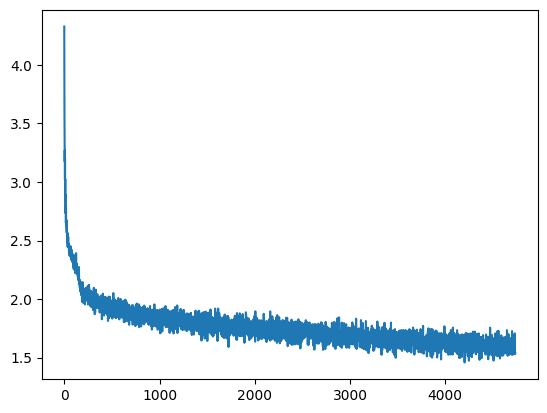

In [135]:
from matplotlib import pyplot as plt
plt.plot(losses)
